# Data Cleaning Pipeline

In [1]:
# Only need to assign the two values below first, then run all
watershed = 'SanJoaquin'
main_str = 'Newman'

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import copy
from pandas.plotting import register_matplotlib_converters
from sklearn import linear_model
from sklearn.metrics import r2_score
import copy
import os
import matplotlib.backends.backend_pdf
lm = linear_model.LinearRegression()
np.random.seed(50)
plt.rcParams.update({'figure.max_open_warning': 0})
register_matplotlib_converters()
os.getcwd()

'/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/27-SanJoaquin/DailyData'

In [3]:
# local functions
import sys
sys.path.insert(1, '/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/Functions')

from Abnormal_data_values_control import outvalues,threC
from Source_QC_functions_L import interpolateQC, regressorFunc, funcClimateCatalog, AssembleClimateCatalog

In [4]:
# Read the original data table
table = pd.read_csv('1_'+watershed+'_Download_Aggregation_Daily.csv',header = 0,index_col = 'DateTime',
                    parse_dates = True, infer_datetime_format = True,low_memory=False)
display(table.head(2))
display(table.tail(2))

Newman_Discharge  Fremont_Discharge  Merced_Discharge  \
DateTime                                                            
2009-10-01         5521.7760         1345.04800         2973.2640   
2009-10-02         6116.4288         1463.97856         3199.7984   

            SanJoaquin_Precipitation  SanJoaquin_AirTemperature  \
DateTime                                                          
2009-10-01                       0.0                  17.174318   
2009-10-02                       0.0                  20.416522   

            SanJoaquin_SolarRadiation  SanJoaquin_RelativeHumidity  \
DateTime                                                             
2009-10-01                 195.278023                          NaN   
2009-10-02                 239.039981                    19.043478   

            SanJoaquin_WindDirection  SanJoaquin_WindSpeed  \
DateTime                                                     
2009-10-01                       NaN                   NaN   
2009-10-02                       NaN                   NaN   

            SanJoaquin_SoilMoisture_30cmP1  SanJoaquin_SoilMoisture_30cmP2  \
DateTime                                                                     
2009-10-01                             NaN                             NaN   
2009-10-02                             NaN                             NaN   

            SanJoaquin_SoilMoisture_30cmP3  SanJoaquin_SoilMoisture_30cmP4  \
DateTime                                                                     
2009-10-01                             NaN                             NaN   
2009-10-02                             NaN                             NaN   

            SanJoaquin_SoilTemperature_5cm  SanJoaquin_SoilTemperature_10cm  \
DateTime                                                                      
2009-10-01                             NaN                              NaN   
2009-10-02                             NaN                              NaN   

            SanJoaquin_SoilTemperature_25cm  SanJoaquin_SoilTemperature_50cm  \
DateTime                                                                       
2009-10-01                              NaN                              NaN   
2009-10-02                              NaN                              NaN   

            SanJoaquin_SoilTemperature_100cm  SanJoaquin_SoilTemperature_200cm  
DateTime                                                                        
2009-10-01                               NaN                               NaN  
2009-10-02                               NaN                               NaN

Newman_Discharge  Fremont_Discharge  Merced_Discharge  \
DateTime                                                            
2018-09-29        14243.3504          4105.9360         5861.5776   
2018-09-30        13393.8464          4049.3024         6116.4288   

            SanJoaquin_Precipitation  SanJoaquin_AirTemperature  \
DateTime                                                          
2018-09-29                       0.0                   19.68375   
2018-09-30                       0.0                   22.15625   

            SanJoaquin_SolarRadiation  SanJoaquin_RelativeHumidity  \
DateTime                                                             
2018-09-29                 204.548081                    38.083333   
2018-09-30                 226.349398                    37.145833   

            SanJoaquin_WindDirection  SanJoaquin_WindSpeed  \
DateTime                                                     
2018-09-29                141.210254              2.207557   
2018-09-30                149.761376              2.072913   

            SanJoaquin_SoilMoisture_30cmP1  SanJoaquin_SoilMoisture_30cmP2  \
DateTime                                                                     
2018-09-29                             NaN                             NaN   
2018-09-30                             NaN                             NaN   

            SanJoaquin_SoilMoisture_30cmP3  SanJoaquin_SoilMoisture_30cmP4  \
DateTime                                                                     
2018-09-29                             NaN                             NaN   
2018-09-30                             NaN                             NaN   

            SanJoaquin_SoilTemperature_5cm  SanJoaquin_SoilTemperature_10cm  \
DateTime                                                                      
2018-09-29                             NaN                              NaN   
2018-09-30                             NaN                              NaN   

            SanJoaquin_SoilTemperature_25cm  SanJoaquin_SoilTemperature_50cm  \
DateTime                                                                       
2018-09-29                              NaN                              NaN   
2018-09-30                              NaN                              NaN   

            SanJoaquin_SoilTemperature_100cm  SanJoaquin_SoilTemperature_200cm  
DateTime                                                                        
2018-09-29                               NaN                               NaN  
2018-09-30                               NaN                               NaN

In [5]:
# Check all the station names
all_stations = table.columns.str.extract(r'([^_]+)')[0]
print('All stations names: ', all_stations.unique())
print ('  ')
nameStrflwStation=[]
nameHydrMetStation=[]
for i in np.arange(len(table.columns)):
    if table.columns[i][-9:]=='Discharge':  ### 
        if not all_stations[i] in nameStrflwStation:
            nameStrflwStation.append(all_stations[i]) ### 
    else:
        if not all_stations[i] in nameHydrMetStation:
            nameHydrMetStation.append(all_stations[i])  ### 

print('Discharge stations :',nameStrflwStation)
print('  ')
print('Meteorology stations:',nameHydrMetStation)                  

All stations names:  ['Newman' 'Fremont' 'Merced' 'SanJoaquin']
  
Discharge stations : ['Newman', 'Fremont', 'Merced']
  
Meteorology stations: ['SanJoaquin']


In [6]:
for i in table.columns:
    if i.split('_')[0] == main_str :
        print(i)

Newman_Discharge


In [7]:
len(nameHydrMetStation)

1

#  1. Trim the original table

In [8]:
# Trim the data and let the table start with first non nan value, end with last non nan value
# Identify the first non nan value in each column as the starting date.
# Identify the last non nan value in each column as the ending date.

t = table.notna() 
t = ~np.isnan(table)
col = len(t.columns)
b = np.zeros([table.shape[1]])
c = np.array([table.shape[0]] * table.shape[1])

for i in range(col):
    if any(t.iloc[:,i]): # Since some are empty
        b[i] = list(np.where(t.iloc[:,i] == True))[0][0] # the first non nan value location
        c[i] = list(np.where(t.iloc[:,i] == True))[0][-1] # the last non nan value location
        
st_tab = b.min()
table1 = table.iloc[int(b.min()):int(c.max()) + 1,:] 

# Display the trimmed table
display(table1.head(2))
display(table1.tail(2))
print('trimmed row number is ', int(table.shape[0] -  table1.shape[0]))

Newman_Discharge  Fremont_Discharge  Merced_Discharge  \
DateTime                                                            
2009-10-01         5521.7760         1345.04800         2973.2640   
2009-10-02         6116.4288         1463.97856         3199.7984   

            SanJoaquin_Precipitation  SanJoaquin_AirTemperature  \
DateTime                                                          
2009-10-01                       0.0                  17.174318   
2009-10-02                       0.0                  20.416522   

            SanJoaquin_SolarRadiation  SanJoaquin_RelativeHumidity  \
DateTime                                                             
2009-10-01                 195.278023                          NaN   
2009-10-02                 239.039981                    19.043478   

            SanJoaquin_WindDirection  SanJoaquin_WindSpeed  \
DateTime                                                     
2009-10-01                       NaN                   NaN   
2009-10-02                       NaN                   NaN   

            SanJoaquin_SoilMoisture_30cmP1  SanJoaquin_SoilMoisture_30cmP2  \
DateTime                                                                     
2009-10-01                             NaN                             NaN   
2009-10-02                             NaN                             NaN   

            SanJoaquin_SoilMoisture_30cmP3  SanJoaquin_SoilMoisture_30cmP4  \
DateTime                                                                     
2009-10-01                             NaN                             NaN   
2009-10-02                             NaN                             NaN   

            SanJoaquin_SoilTemperature_5cm  SanJoaquin_SoilTemperature_10cm  \
DateTime                                                                      
2009-10-01                             NaN                              NaN   
2009-10-02                             NaN                              NaN   

            SanJoaquin_SoilTemperature_25cm  SanJoaquin_SoilTemperature_50cm  \
DateTime                                                                       
2009-10-01                              NaN                              NaN   
2009-10-02                              NaN                              NaN   

            SanJoaquin_SoilTemperature_100cm  SanJoaquin_SoilTemperature_200cm  
DateTime                                                                        
2009-10-01                               NaN                               NaN  
2009-10-02                               NaN                               NaN

Newman_Discharge  Fremont_Discharge  Merced_Discharge  \
DateTime                                                            
2018-09-29        14243.3504          4105.9360         5861.5776   
2018-09-30        13393.8464          4049.3024         6116.4288   

            SanJoaquin_Precipitation  SanJoaquin_AirTemperature  \
DateTime                                                          
2018-09-29                       0.0                   19.68375   
2018-09-30                       0.0                   22.15625   

            SanJoaquin_SolarRadiation  SanJoaquin_RelativeHumidity  \
DateTime                                                             
2018-09-29                 204.548081                    38.083333   
2018-09-30                 226.349398                    37.145833   

            SanJoaquin_WindDirection  SanJoaquin_WindSpeed  \
DateTime                                                     
2018-09-29                141.210254              2.207557   
2018-09-30                149.761376              2.072913   

            SanJoaquin_SoilMoisture_30cmP1  SanJoaquin_SoilMoisture_30cmP2  \
DateTime                                                                     
2018-09-29                             NaN                             NaN   
2018-09-30                             NaN                             NaN   

            SanJoaquin_SoilMoisture_30cmP3  SanJoaquin_SoilMoisture_30cmP4  \
DateTime                                                                     
2018-09-29                             NaN                             NaN   
2018-09-30                             NaN                             NaN   

            SanJoaquin_SoilTemperature_5cm  SanJoaquin_SoilTemperature_10cm  \
DateTime                                                                      
2018-09-29                             NaN                              NaN   
2018-09-30                             NaN                              NaN   

            SanJoaquin_SoilTemperature_25cm  SanJoaquin_SoilTemperature_50cm  \
DateTime                                                                       
2018-09-29                              NaN                              NaN   
2018-09-30                              NaN                              NaN   

            SanJoaquin_SoilTemperature_100cm  SanJoaquin_SoilTemperature_200cm  
DateTime                                                                        
2018-09-29                               NaN                               NaN  
2018-09-30                               NaN                               NaN

trimmed row number is  0


### Drop columns without data

In [9]:
tt = copy.deepcopy(table1)
for dd in np.arange(len(tt.columns)):
    if all(pd.isna(tt.iloc[:,dd])):
        print('The empty column is ', dd,tt.columns[dd])
        table1.drop(columns = tt.columns[dd], axis=1, inplace = True)

var_number = table1.shape[1] 

if table1.shape[1]  == table.shape[1] :
    print('There are no empty columns!')

The empty column is  13 SanJoaquin_SoilTemperature_5cm
The empty column is  15 SanJoaquin_SoilTemperature_25cm


/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [10]:
table1.to_csv('1_SanJoaquin_Download_Aggregation_Daily.csv', sep=',')

### Save the original discharge table seperately

In [11]:
DischargeTable = pd.DataFrame(index = table1.index)
for i in np.arange(len(nameStrflwStation)):
    DischargeTable[nameStrflwStation[i]+'_Discharge'] = table1.loc[:,nameStrflwStation[i]+'_Discharge']

DischargeTable.to_csv('1_'+ watershed + '_DischargeTable.csv')

# 2. Data filling method: Interpolation

 
0 Newman_Discharge :No missing data!
 
1 Fremont_Discharge :No missing data!
2 Merced_Discharge index of interpolated length = 76
No filled values are out of original data range
 
3 SanJoaquin_Precipitation index of interpolated length = 33
No filled values are out of original data range
 
4 SanJoaquin_AirTemperature index of interpolated length = 223
No filled values are out of original data range
 
5 SanJoaquin_SolarRadiation index of interpolated length = 33
No filled values are out of original data range
 
6 SanJoaquin_RelativeHumidity index of interpolated length = 223
No filled values are out of original data range
 
7 SanJoaquin_WindDirection index of interpolated length = 282
No filled values are out of original data range
 
8 SanJoaquin_WindSpeed index of interpolated length = 282
No filled values are out of original data range
 
9 SanJoaquin_SoilMoisture_30cmP1 index of interpolated length = 208
No filled values are out of original data range
 
10 SanJoaquin_SoilMoisture_30

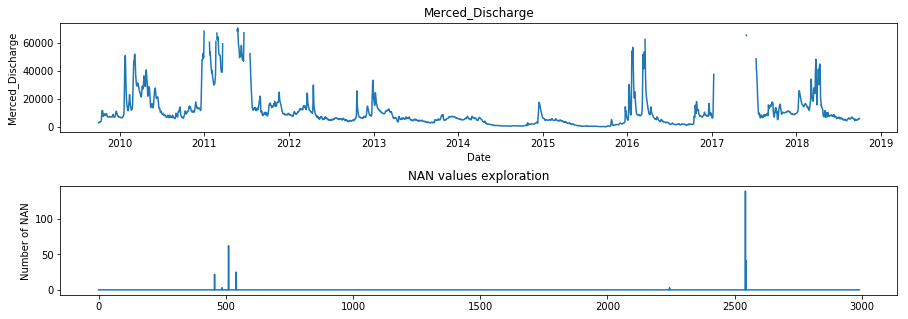

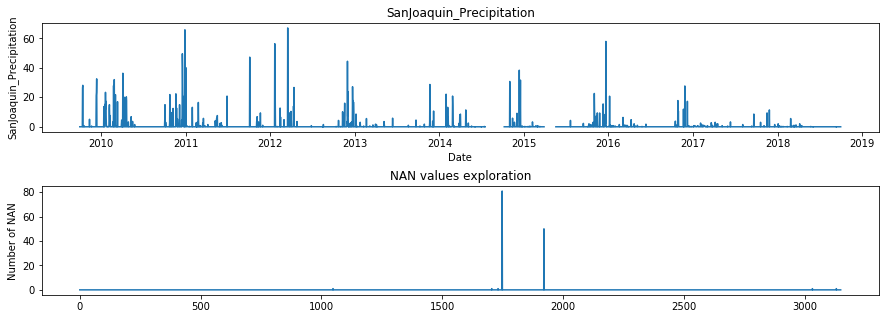

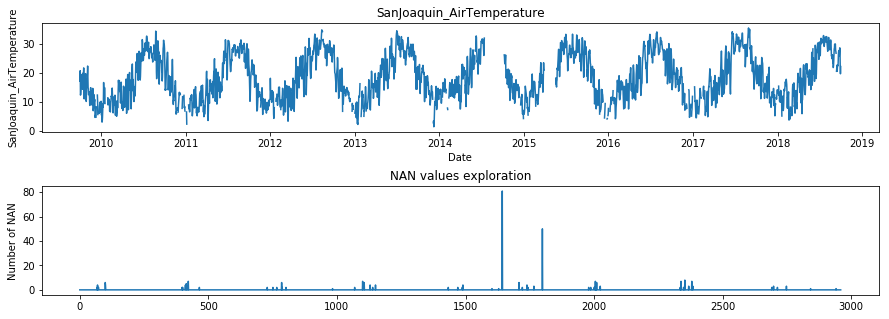

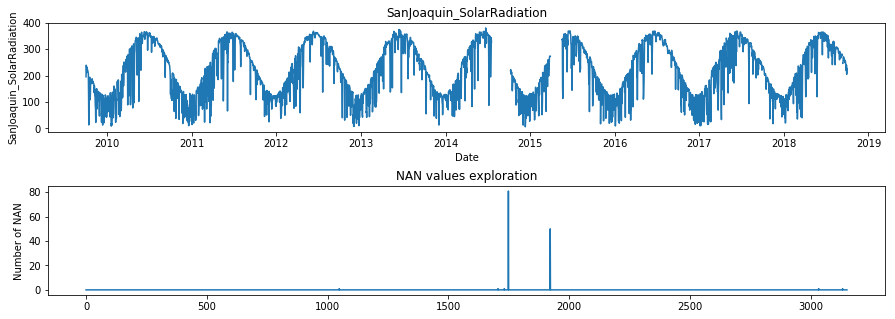

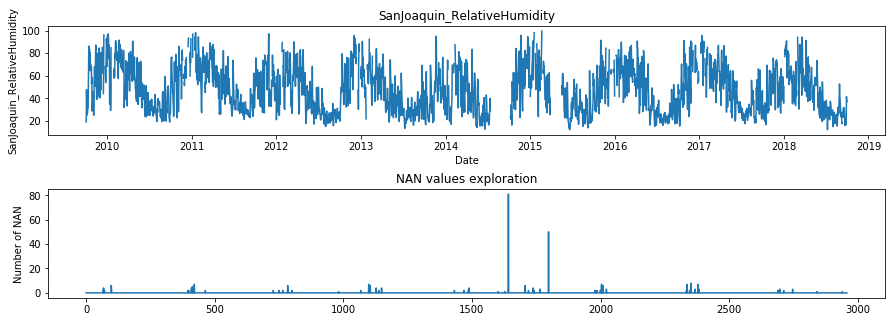

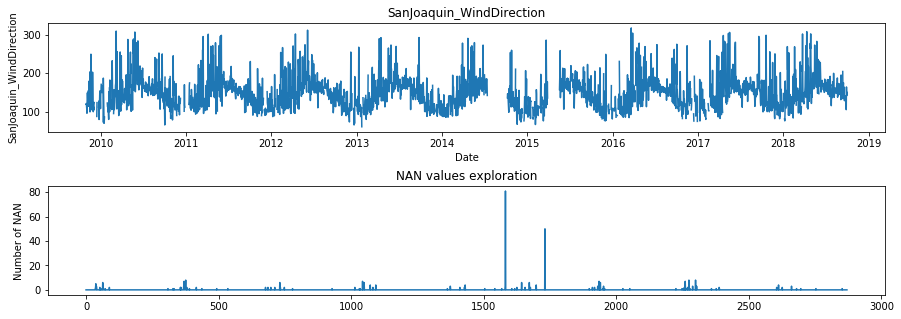

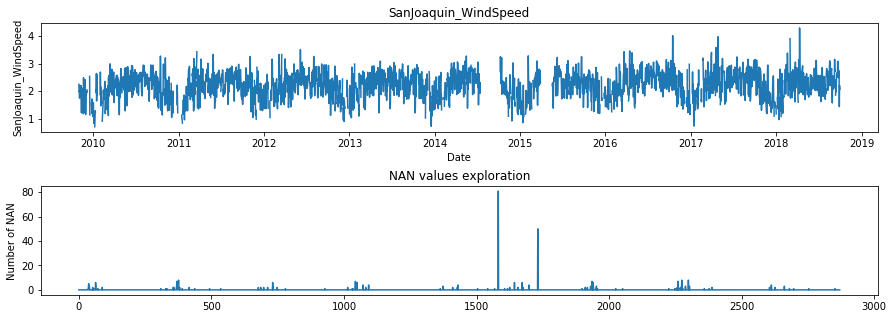

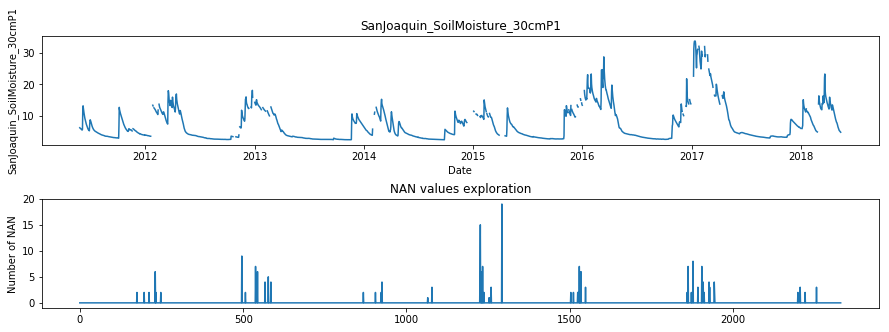

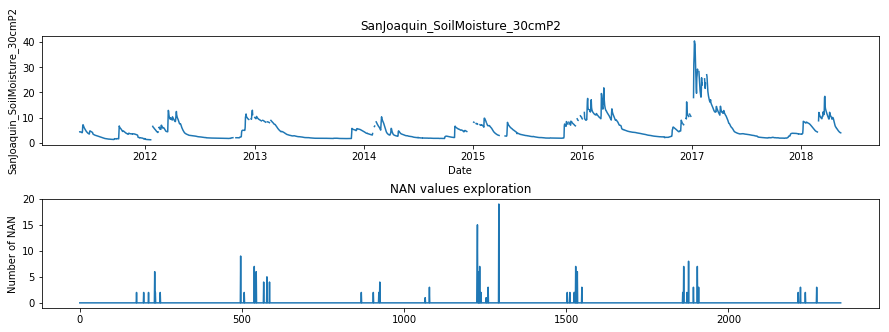

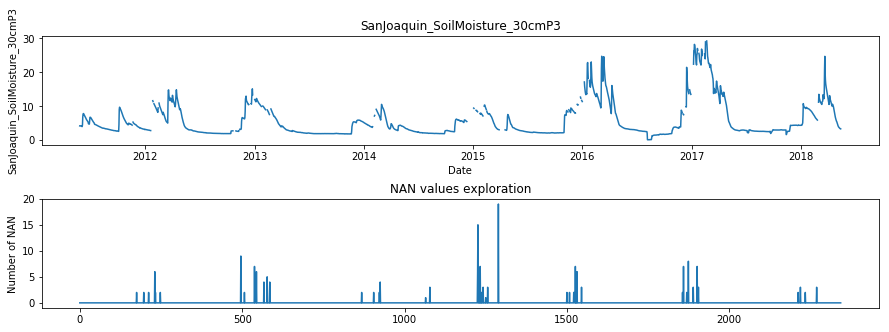

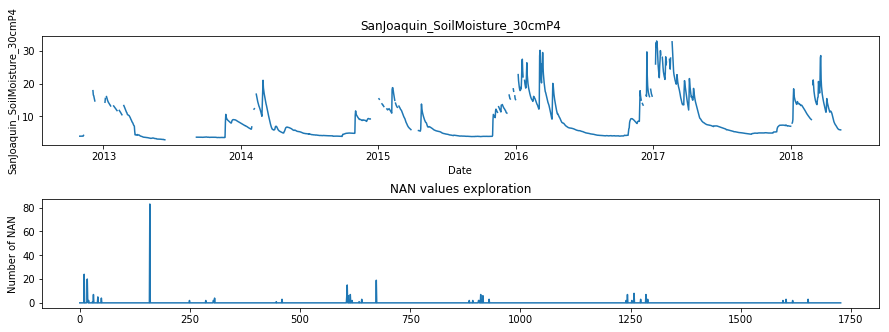

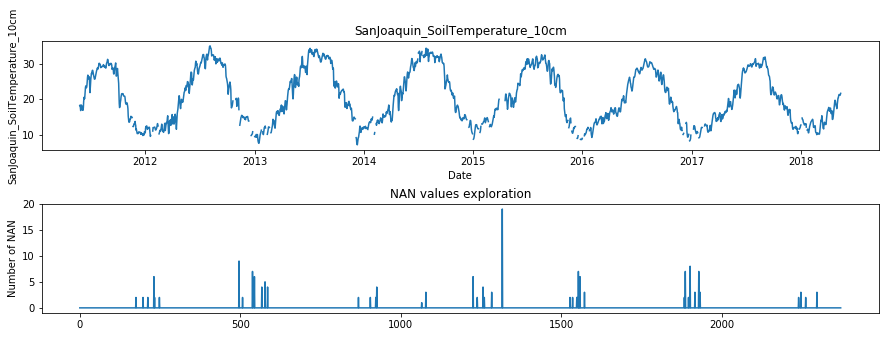

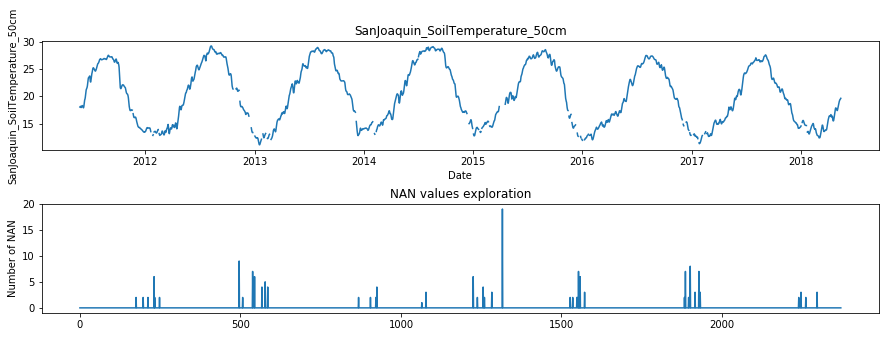

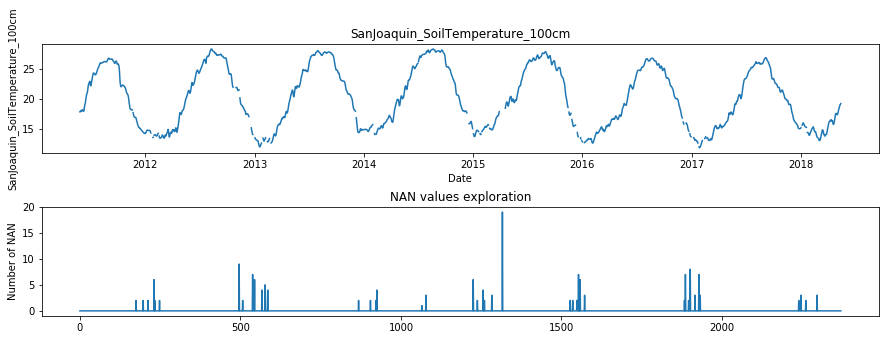

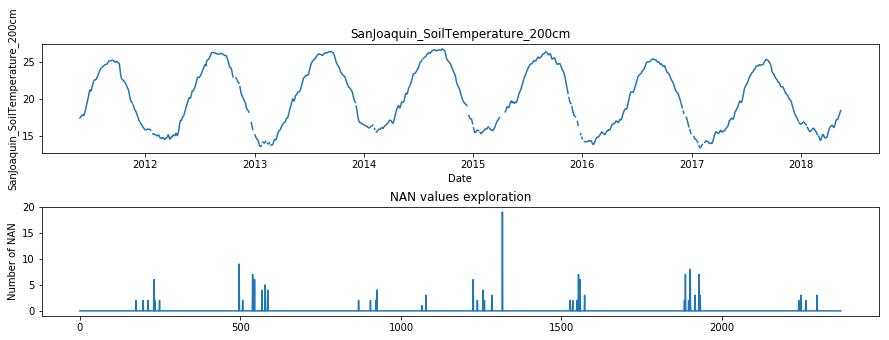

In [12]:
# =====================================
# First data exploration with plots.
# Check the number of Missing values.
# Do interpolation on the missing values positions

# table 2 will be used to be updated with interpolated values
table2=copy.deepcopy(table1) 

# a dictionary that store data record for each column
y1={} 

# Create a flag table(flag_table2) to store interpolation indicators
indexUnique=table2.index
ready_columns=pd.unique(table2.columns) 
if len(pd.unique(table2.columns))!=len(table2.columns):
    print("Duplicate columns exist!")
flag_table2=pd.DataFrame(np.nan*np.ones([len(indexUnique),len(ready_columns)]),
                 index = indexUnique, columns=ready_columns) 


for k,VarName in enumerate(ready_columns): # column of variable being processed 
    y1[k]=table2[VarName].copy(deep = True)
    ind=np.where(~np.isnan(y1[k].to_numpy())) # index where y1 has value (not NaN)
    flag_table2[VarName][ind[0]] = int(1) # set indicator 1 to original data positions
    start = ind[0][0]
    end = ind[0][-1]
    missing_index = list(set(range(start,end+1)) - set(ind[0]))
    flag_table2[VarName][missing_index] = int(0) # set indicator 0 to missing data positions
    y1[k] = y1[k][start:end+1] # trim y1   
    
    # Print out whether the column contain missing values
    dim = np.shape(ind)[1] # number of exsiting data points 
    if (dim != len(y1[k])): # there are missing data
        #===========================
        # For those columns that contain missing values:Plot the data and indicate nan values position and length
        fig1 = plt.figure(figsize=[15,5])
        sp1, sp2 = fig1.add_subplot(211), fig1.add_subplot(212)
        sp1.plot(y1[k])
        sp1.set_title(table2.columns[k])
        sp1.set_xlabel('Date')
        sp1.set_ylabel(table2.columns[k])
    
        index = np.argwhere(~np.isnan(y1[k].to_numpy())) # An array of index that the value is not nan (where data exist)
        lenNAN = (np.diff(index,axis=0)) - 1 # An array that indicate the NAN value number along data record

        pd.DataFrame(lenNAN)
        sp2.plot(lenNAN)
        sp2.set_title("NAN values exploration")
        sp2.set_ylabel('Number of NAN')
        plt.subplots_adjust(hspace=0.5)

        #===========================
        # For those columns that contain missing values: Do Interpolation 
        y2, nanR, whereINT=interpolateQC(pd.DataFrame(y1[k]),inteplimit = 7,name = VarName,k=k) # maximum interpolation length is 3! days
        # Update table 3 with interpolated values
        table2.loc[:,VarName]=y2[0] 
        
        # Update flag table with interpolation indicators 2
        flag_table2[VarName][np.reshape(whereINT[0], whereINT[0].shape[0])+start] = int(2) 
        
        # Check if the value is out of original threshold, don't forget to change flag table as well
        outvalues(table, table2, flag_table2, VarName)
        print(" ")
    else:    
        print(" ")
        print(k,VarName, ":No missing data!")

### Store the data table and the flag table after interpolation

In [13]:
flag_table2.head(2)

Newman_Discharge  Fremont_Discharge  Merced_Discharge  \
DateTime                                                            
2009-10-01               1.0                1.0               1.0   
2009-10-02               1.0                1.0               1.0   

            SanJoaquin_Precipitation  SanJoaquin_AirTemperature  \
DateTime                                                          
2009-10-01                       1.0                        1.0   
2009-10-02                       1.0                        1.0   

            SanJoaquin_SolarRadiation  SanJoaquin_RelativeHumidity  \
DateTime                                                             
2009-10-01                        1.0                          NaN   
2009-10-02                        1.0                          1.0   

            SanJoaquin_WindDirection  SanJoaquin_WindSpeed  \
DateTime                                                     
2009-10-01                       NaN                   NaN   
2009-10-02                       NaN                   NaN   

            SanJoaquin_SoilMoisture_30cmP1  SanJoaquin_SoilMoisture_30cmP2  \
DateTime                                                                     
2009-10-01                             NaN                             NaN   
2009-10-02                             NaN                             NaN   

            SanJoaquin_SoilMoisture_30cmP3  SanJoaquin_SoilMoisture_30cmP4  \
DateTime                                                                     
2009-10-01                             NaN                             NaN   
2009-10-02                             NaN                             NaN   

            SanJoaquin_SoilTemperature_10cm  SanJoaquin_SoilTemperature_50cm  \
DateTime                                                                       
2009-10-01                              NaN                              NaN   
2009-10-02                              NaN                              NaN   

            SanJoaquin_SoilTemperature_100cm  SanJoaquin_SoilTemperature_200cm  
DateTime                                                                        
2009-10-01                               NaN                               NaN  
2009-10-02                               NaN                               NaN

In [14]:
table2.to_csv('2_' + watershed + '_Interpolation.csv', sep=',')
flag_table2.to_csv('2_' + watershed + '_Interpolation_Flag.csv', sep=',')
all(table2.columns == flag_table2.columns)

True

# 3. Data filling method: Regression (across stations)

In [15]:
# Some functions to be used
def get_ind(table,var):
    nameTab = pd.Series(table.columns)
    n_Tab = nameTab.apply(lambda x: x.split('_'))[:]
    var_stn = table.columns[n_Tab.apply(lambda x: x[1] == var)]
    range_all = np.array([np.where(~np.isnan(table[c].to_numpy()))[0] for c in var_stn])
    start = np.min([x[0] for x in range_all])
    end = np.max([x[-1] for x in range_all])
    ind = table.index[start:end+1]
    return ind 

def fromEveryStationPoolAvariable(stn_names,var,ind,stn_table_dic): 
# stn_names is names for all stns, var is a variable name, ind is the index of stn i 
# stn_table_dic is a dictionary storing data by stn, nn is an empty df
    nn = pd.DataFrame(index=ind)
    for k in np.arange(len(stn_names)): # read the station table
        tabReg2 = stn_table_dic[k] # the table for stn k
        for m in np.arange(len(tabReg2.columns)): # for each observation at stn k
             if str.find(tabReg2.columns[m],var) != -1: # stn k has observation for this variable(var)
                useful_col=tabReg2.columns[m]
                ind2=get_ind(tabReg2,var)
                overlap_time=pd.Series(list(set(ind)&set(ind2)))
                if len(overlap_time)!=0: #stn i and stn k have overlapped time range for var
                    nn.loc[overlap_time,useful_col] = tabReg2.loc[overlap_time,useful_col] #get the data of this variable at stn k                
                
    return nn


def regressionAtStationForAvariable(nn,stnName,var): #stnName = stn_names[i]
    nameTab = pd.Series(nn.columns)
    n_Tab = nameTab.apply(lambda x: x.split('_'))[:]
    stnofInterest = n_Tab.apply(lambda x: x[0] == stnName) # station name is at the beigning
    colInt = np.argwhere(stnofInterest.to_numpy() == 1)  
    mesName = nn.columns # all the column names for this variable(var)   
    
    for col in colInt:
        p = np.delete(np.arange(len(mesName)), col)# get rid of the col that will be apply regression method
        tt = nn.iloc[:,np.r_[col,p]]# put the target col at the first
        regR = regressorFunc(tt,regThres=0.7)

        
        # return ind_interp
        # location where Regression happened
        #ind_interp = np.argwhere(regR != nn.iloc[:,col].to_numpy()) # this is commented out because it can't discriminate nan values
  
        # plot 
        plt.figure(figsize=[5,1])
        plt.plot(regR,color='black',label= var+' After regression')
        plt.plot(np.array(nn.iloc[:,col]), color='red', label='Raw data')        
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.title(nn.columns[col])    
        
        # Update the variable table
        nn.iloc[:,col] = regR
    return nn

### Do regression across all stations

In [16]:
# table3 will be updated with regression values
table3 = copy.deepcopy(table2)
flag_table3 = copy.deepcopy(flag_table2)

In [17]:
# Store tables into a dictionary seperated by stations, store the data after interpolation
stn_table_dic = {}
col_names = pd.Series(table2.columns)
n_tab = col_names.apply(lambda x: x.split('_'))[:]
var_names = n_tab.apply(lambda x: x[1]).unique()
stn_names = n_tab.apply(lambda x: x[0]).unique()
print('var_names:',var_names)

for i in range(len(stn_names)): # column of variable being processed
    station = stn_names[i] 
    #print(station)
    station_lst = []
    for col in col_names:
        if col.split('_')[0] == station:
            station_lst.append(col)
    #print(station_lst)
    stn_table_dic[i] = copy.deepcopy(table2[station_lst])
    
# check if the results of all station have been stored
len(stn_table_dic.keys()) == len(stn_names)

var_names: ['Discharge' 'Precipitation' 'AirTemperature' 'SolarRadiation'
 'RelativeHumidity' 'WindDirection' 'WindSpeed' 'SoilMoisture'
 'SoilTemperature']


True

1 / 4 in process: Newman Discharge
 
No Precipitation data at station Newman
 
No AirTemperature data at station Newman
 
No SolarRadiation data at station Newman
 
No RelativeHumidity data at station Newman
 
No WindDirection data at station Newman
 
No WindSpeed data at station Newman
 
No SoilMoisture data at station Newman
 
No SoilTemperature data at station Newman
 
2 / 4 in process: Fremont Discharge
 
No Precipitation data at station Fremont
 
No AirTemperature data at station Fremont
 
No SolarRadiation data at station Fremont
 
No RelativeHumidity data at station Fremont
 
No WindDirection data at station Fremont
 
No WindSpeed data at station Fremont
 
No SoilMoisture data at station Fremont
 
No SoilTemperature data at station Fremont
 
3 / 4 in process: Merced Discharge
 
No Precipitation data at station Merced
 
No AirTemperature data at station Merced
 
No SolarRadiation data at station Merced
 
No RelativeHumidity data at station Merced
 
No WindDirection data at statio

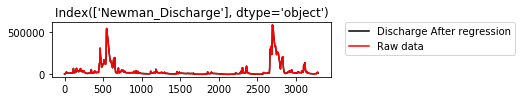

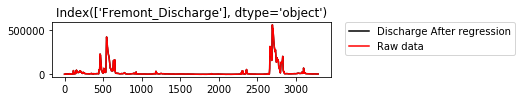

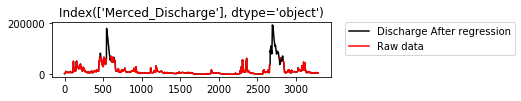

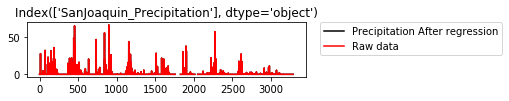

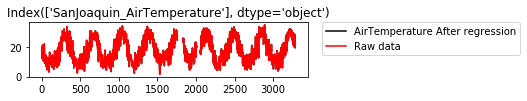

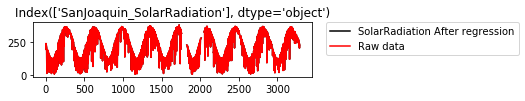

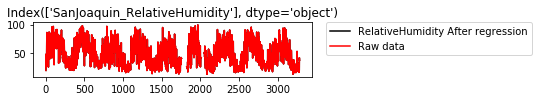

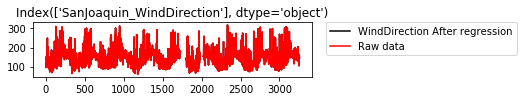

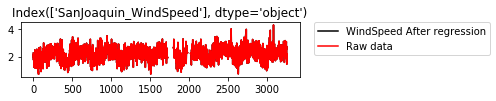

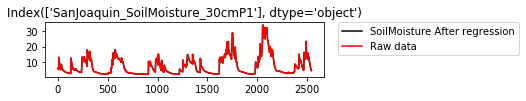

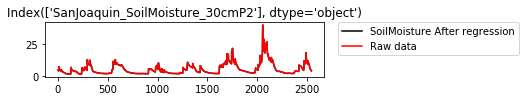

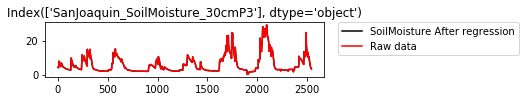

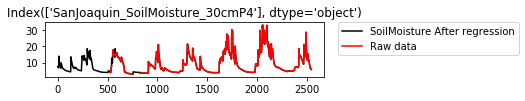

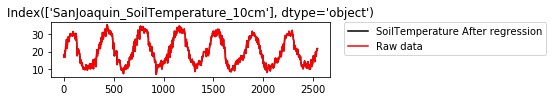

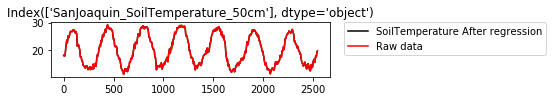

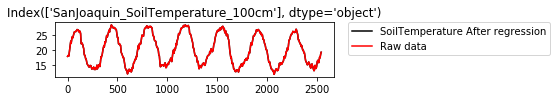

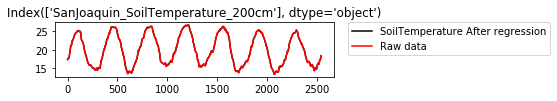

In [18]:
%%time
for i in np.arange(len(stn_names)): # Each met station
    tabReg = stn_table_dic[i]  # extract the table for station i from the dictionary
    for j in np.arange(len(var_names)): # loop across variables, not looping for discharge
        var = var_names[j] # for each meteorology variable
        if var in pd.unique(np.array([c.split('_')[1] for c in tabReg.columns])):
            ind = get_ind(tabReg,var)
            print(i+1,"/",len(stn_names),"in process:",stn_names[i],var)
            # Fill single variable from multiple stations
            nn = fromEveryStationPoolAvariable(stn_names, var, ind, stn_table_dic)
            ## nn is a df storing the all the data for the same variable(var)

            # Do regression across stations for met station i, variable j
            result = regressionAtStationForAvariable(nn, stn_names[i], var)
            regressed_cols = pd.Series(list(set(result.columns) & set(tabReg.columns)),dtype='object') # column where regression is done
            
            # Update table3 with regression results
            #print('Finishing regression on Station', stn_names[i], var) 
            for k in np.arange(len(regressed_cols)):
                rcol=regressed_cols[k]
                reg=result[rcol]
                table3.loc[reg.index[0]:reg.index[-1],rcol] = np.array(reg)
        else:
            print("No",var,"data at station",stn_names[i])
        print(' ')

In [19]:
# Write indicators of regression into flag table
for j in range(len(col_names)):
    col = col_names[j]
    for m in table3[col].index:  
        if str(table2[col][m]) == 'nan':
            if str(table3[col][m])!= 'nan':
                flag_table3[col][m] = int(3)

In [20]:
# Check the regression values and delete out of range values
for col in col_names:
    outvalues(table, table3, flag_table3, col)

No filled values are out of original data range
No filled values are out of original data range
Merced_Discharge More than maximum, value 82979.16969621436 > 70792.0 index =  464
Merced_Discharge More than maximum, value 80412.92231460629 > 70792.0 index =  465
Merced_Discharge More than maximum, value 80504.57400680658 > 70792.0 index =  466
Merced_Discharge More than maximum, value 78396.58508619994 > 70792.0 index =  467
Merced_Discharge More than maximum, value 74180.60724498669 > 70792.0 index =  468
Merced_Discharge More than maximum, value 178021.9745079135 > 70792.0 index =  544
Merced_Discharge More than maximum, value 178938.49142991635 > 70792.0 index =  545
Merced_Discharge More than maximum, value 179855.00835191924 > 70792.0 index =  546
Merced_Discharge More than maximum, value 176188.94066390768 > 70792.0 index =  547
Merced_Discharge More than maximum, value 167940.28836588172 > 70792.0 index =  548
Merced_Discharge More than maximum, value 164274.22067787018 > 70792.0

No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range


In [21]:
# Store the data table and the flag table
table3.to_csv('3_'+watershed+'_Regression.csv', sep=',')
flag_table3.to_csv('3_'+watershed+'_Regression_Flag.csv', sep=',')

# 4. Data filling method: Climate Catalog

In [22]:
# Extract discharge table
DischargeTable = pd.DataFrame(index = table3.index)
for i in np.arange(len(nameStrflwStation)):
    DischargeTable[nameStrflwStation[i]+'_Discharge'] = table3.loc[:,nameStrflwStation[i]+'_Discharge']
DischargeTable.head(2)

Newman_Discharge  Fremont_Discharge  Merced_Discharge
DateTime                                                         
2009-10-01         5521.7760         1345.04800         2973.2640
2009-10-02         6116.4288         1463.97856         3199.7984

In [23]:
y3 = {}
for i in np.arange(len(table3.columns)):
    col_name = table3.columns[i]
    range_y3 = np.where(~np.isnan(table3[col_name].to_numpy()))[0]
    start = range_y3[0]
    end = range_y3[-1]
    y3[i] = table3[col_name][start:end+1]
AnT = funcClimateCatalog(table3, y3, 270, watershed, 0.7) # divide the data by year
table4,whereClimateCat = AssembleClimateCatalog(AnT, y3, table3, watershed)

0 Newman_Discharge 0
1 Fremont_Discharge 0
2 Merced_Discharge 47
3 SanJoaquin_Precipitation 103
4 SanJoaquin_AirTemperature 103
5 SanJoaquin_SolarRadiation 103
6 SanJoaquin_RelativeHumidity 103
7 SanJoaquin_WindDirection 103
8 SanJoaquin_WindSpeed 103
9 SanJoaquin_SoilMoisture_30cmP1 6
10 SanJoaquin_SoilMoisture_30cmP2 6
11 SanJoaquin_SoilMoisture_30cmP3 6
12 SanJoaquin_SoilMoisture_30cmP4 6
13 SanJoaquin_SoilTemperature_10cm 5
14 SanJoaquin_SoilTemperature_50cm 5
15 SanJoaquin_SoilTemperature_100cm 5
16 SanJoaquin_SoilTemperature_200cm 5


In [24]:
# Write indicators of ClimateCatalog into flag table4
flag_table4 = copy.deepcopy(flag_table3)
for j in range(len(col_names)):
    col = col_names[j]
    for m in table4[col].index:  
        if str(table3[col][m]) == 'nan':
            if str(table4[col][m])!= 'nan':
                flag_table4[col][m] = int(4)

In [25]:
# Check the regression values and delete out of range values
for col in col_names:
    outvalues(table, table4, flag_table4, col)

No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range


In [26]:
# Store the data table and the flag table
table4.to_csv('4_'+watershed+'_ClimateCatalog.csv', sep=',')
flag_table4.to_csv('4_'+watershed+'_ClimateCatalog_Flag.csv', sep=',')

In [27]:
table4.head()

Newman_Discharge  Fremont_Discharge  Merced_Discharge  \
DateTime                                                            
2009-10-01         5521.7760         1345.04800         2973.2640   
2009-10-02         6116.4288         1463.97856         3199.7984   
2009-10-03         6258.0128         1701.83968         3313.0656   
2009-10-04         6173.0624         1826.43360         3313.0656   
2009-10-05         6711.0816         2052.96800         3567.9168   

            SanJoaquin_Precipitation  SanJoaquin_AirTemperature  \
DateTime                                                          
2009-10-01                       0.0                  17.174318   
2009-10-02                       0.0                  20.416522   
2009-10-03                       0.0                  20.741702   
2009-10-04                       0.0                  12.382292   
2009-10-05                       0.0                  12.663542   

            SanJoaquin_SolarRadiation  SanJoaquin_RelativeHumidity  \
DateTime                                                             
2009-10-01                 195.278023                          NaN   
2009-10-02                 239.039981                    19.043478   
2009-10-03                 231.858824                    19.936170   
2009-10-04                 211.295076                    47.708333   
2009-10-05                 231.767220                    36.854167   

            SanJoaquin_WindDirection  SanJoaquin_WindSpeed  \
DateTime                                                     
2009-10-01                       NaN                   NaN   
2009-10-02                       NaN                   NaN   
2009-10-03                       NaN                   NaN   
2009-10-04                       NaN                   NaN   
2009-10-05                       NaN                   NaN   

            SanJoaquin_SoilMoisture_30cmP1  SanJoaquin_SoilMoisture_30cmP2  \
DateTime                                                                     
2009-10-01                             NaN                             NaN   
2009-10-02                             NaN                             NaN   
2009-10-03                             NaN                             NaN   
2009-10-04                             NaN                             NaN   
2009-10-05                             NaN                             NaN   

            SanJoaquin_SoilMoisture_30cmP3  SanJoaquin_SoilMoisture_30cmP4  \
DateTime                                                                     
2009-10-01                             NaN                             NaN   
2009-10-02                             NaN                             NaN   
2009-10-03                             NaN                             NaN   
2009-10-04                             NaN                             NaN   
2009-10-05                             NaN                             NaN   

            SanJoaquin_SoilTemperature_10cm  SanJoaquin_SoilTemperature_50cm  \
DateTime                                                                       
2009-10-01                              NaN                              NaN   
2009-10-02                              NaN                              NaN   
2009-10-03                              NaN                              NaN   
2009-10-04                              NaN                              NaN   
2009-10-05                              NaN                              NaN   

            SanJoaquin_SoilTemperature_100cm  SanJoaquin_SoilTemperature_200cm  
DateTime                                                                        
2009-10-01                               NaN                               NaN  
2009-10-02                               NaN                               NaN  
2009-10-03                               NaN                               NaN  
2009-10-04                               NaN                            

In [28]:
flag_table4.head()

Newman_Discharge  Fremont_Discharge  Merced_Discharge  \
DateTime                                                            
2009-10-01               1.0                1.0               1.0   
2009-10-02               1.0                1.0               1.0   
2009-10-03               1.0                1.0               1.0   
2009-10-04               1.0                1.0               1.0   
2009-10-05               1.0                1.0               1.0   

            SanJoaquin_Precipitation  SanJoaquin_AirTemperature  \
DateTime                                                          
2009-10-01                       1.0                        1.0   
2009-10-02                       1.0                        1.0   
2009-10-03                       1.0                        1.0   
2009-10-04                       1.0                        1.0   
2009-10-05                       1.0                        1.0   

            SanJoaquin_SolarRadiation  SanJoaquin_RelativeHumidity  \
DateTime                                                             
2009-10-01                        1.0                          NaN   
2009-10-02                        1.0                          1.0   
2009-10-03                        1.0                          1.0   
2009-10-04                        1.0                          1.0   
2009-10-05                        1.0                          1.0   

            SanJoaquin_WindDirection  SanJoaquin_WindSpeed  \
DateTime                                                     
2009-10-01                       NaN                   NaN   
2009-10-02                       NaN                   NaN   
2009-10-03                       NaN                   NaN   
2009-10-04                       NaN                   NaN   
2009-10-05                       NaN                   NaN   

            SanJoaquin_SoilMoisture_30cmP1  SanJoaquin_SoilMoisture_30cmP2  \
DateTime                                                                     
2009-10-01                             NaN                             NaN   
2009-10-02                             NaN                             NaN   
2009-10-03                             NaN                             NaN   
2009-10-04                             NaN                             NaN   
2009-10-05                             NaN                             NaN   

            SanJoaquin_SoilMoisture_30cmP3  SanJoaquin_SoilMoisture_30cmP4  \
DateTime                                                                     
2009-10-01                             NaN                             NaN   
2009-10-02                             NaN                             NaN   
2009-10-03                             NaN                             NaN   
2009-10-04                             NaN                             NaN   
2009-10-05                             NaN                             NaN   

            SanJoaquin_SoilTemperature_10cm  SanJoaquin_SoilTemperature_50cm  \
DateTime                                                                       
2009-10-01                              NaN                              NaN   
2009-10-02                              NaN                              NaN   
2009-10-03                              NaN                              NaN   
2009-10-04                              NaN                              NaN   
2009-10-05                              NaN                              NaN   

            SanJoaquin_SoilTemperature_100cm  SanJoaquin_SoilTemperature_200cm  
DateTime                                                                        
2009-10-01                               NaN                               NaN  
2009-10-02                               NaN                               NaN  
2009-10-03                               NaN                               NaN  
2009-10-04                               NaN                            

In [29]:
table4.shape

(3287, 17)

In [30]:
flag_table4.shape

(3287, 17)